In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import wandb

pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 200)

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kazadaevms. Use `wandb login --relogin` to force relogin


True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from library.load import TRADING_DAYS_IN_YEAR
from library.dataset import load_train_test_dataset, Observation
from library.correlations import get_correlation_matrices, N_REMAINING_COMPONENTS, CorrelationMatrices


observations_train, observations_test = load_train_test_dataset()
correlations_train, correlations_test = get_correlation_matrices(observations_train, True, N_REMAINING_COMPONENTS, N_REMAINING_COMPONENTS), get_correlation_matrices(observations_test, True, N_REMAINING_COMPONENTS, N_REMAINING_COMPONENTS)

Original number of tickers: 246
Drop tickers: ['IRAO']
Start date = 2013-12-16
Filtered number of tickers: 30
Stocks: ['AFLT', 'ALRS', 'GCHE', 'HYDR', 'LKOH', 'LSRG', 'MGNT', 'MOEX', 'MRKC', 'MRKP', 'MSNG', 'MSRS', 'MTLR', 'MTLRP', 'MTSS', 'NVTK', 'PHOR', 'PIKK', 'POLY', 'RTKM', 'RTKMP', 'SBER', 'SBERP', 'TATN', 'TATNP', 'TGKA', 'TRMK', 'TRNFP', 'UTAR', 'VTBR']
DataFrame size after merge: 2255
DataFrame size after removing some years: 1753

2015 year: 246 observations
2016 year: 252 observations
2017 year: 252 observations
2018 year: 246 observations
2019 year: 252 observations
2020 year: 250 observations
2021 year: 255 observations

Train size: 1227. Test size: 526. Test ratio: 0.3000570450656018
Train: 1101. Test: 472. Test ratio: 0.3000635727908455


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
from enum import Enum, auto
from torch.utils.data import Dataset, DataLoader


class TargetType(Enum):
    NEXT_RETURN = auto()  # vector of returns if we invest in stocks now
    NEXT_RETURNS = auto()

class FeaturesType(Enum):
    MEAN_RETURNS = auto()
    CORRELATION_MATRIX = auto()


class PortfolioDataset(Dataset):
    def __init__(self, observations: list[Observation], correlations: CorrelationMatrices, target_type: TargetType, features_types: list[FeaturesType], features_types_params: dict[str, str]):
        # save data
        assert len(observations) == len(correlations.returns)
        self.observations = observations
        self.correlations = correlations
        self.target_type = target_type
        self.features_types = features_types
        self.features_types_params = features_types_params
        self.length = len(observations)

        # construct features and targets
        self.features = self._compute_features()
        self.targets = self._compute_targets()

    def _compute_targets(self) -> list[torch.tensor]:
        targets = []
        for i in range(self.length):
            observation = self.observations[i]
            if self.target_type == TargetType.NEXT_RETURN:
                target = self._pandas_to_tensor(observation.next_returns)
            elif self.target_type == TargetType.NEXT_RETURNS:
                target = self._pandas_to_tensor(observation.df_returns_test)
            else:
                assert False, 'Unreachable'
            targets.append(target)
        return targets

    def _compute_features(self) -> list[torch.tensor]:
        result = []
        for i in range(self.length):
            observation = self.observations[i]
            features_list = []
            for feature_type in self.features_types:
                if feature_type == FeaturesType.MEAN_RETURNS:
                    features = self._pandas_to_tensor(self.correlations.returns[i].mean(axis=0))
                else:
                    assert False, 'Unreachable'
                features_list.append(features)
            features = torch.cat([f.reshape(-1) for f in features_list])
            result.append(features)
        return result

    @staticmethod
    def _pandas_to_tensor(array):
        return torch.from_numpy(array.values.astype(np.float32))

    def __getitem__(self, index: int) -> tuple[torch.tensor, torch.tensor]:
        return self.features[index], self.targets[index]

    def __len__(self):
        return self.length

In [6]:
# Choose dataset params:
# dataset_params = (TargetType.NEXT_RETURN, [FeaturesType.MEAN_RETURNS], {})
dataset_params = (TargetType.NEXT_RETURNS, [FeaturesType.MEAN_RETURNS], {})


train_dataset = PortfolioDataset(observations_train, correlations_train, *dataset_params)
val_dataset = PortfolioDataset(observations_test, correlations_test, *dataset_params)
print(f'Train: {len(train_dataset)}. Test: {len(val_dataset)}')


BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

tmp_features, tmp_targets = next(iter(train_loader))
print(tmp_features.size(), tmp_targets.size())

Train: 1101. Test: 472
torch.Size([32, 30]) torch.Size([32, 90, 30])


In [7]:
from torch import nn


class ReturnCriterion(nn.Module):
    def forward(self, weights, returns):
        return -(weights * returns).sum(dim=-1).mean()  # maximize return

    def print_metric(self, train_loss: float, val_loss: float, baseline_loss):
        train_loss = -train_loss * 100
        val_loss = -val_loss * 100
        baseline_loss = -baseline_loss * 100
        print(f'Day return: val={val_loss:.4f}%; train={train_loss:.4f}%; baseline={baseline_loss:.4f}')
        print(f'Annual return: val={val_loss * TRADING_DAYS_IN_YEAR:.2f}%; train={train_loss * TRADING_DAYS_IN_YEAR:.2f}%; baseline={baseline_loss * TRADING_DAYS_IN_YEAR:.2f}')


class SigmaMinusReturnConstantWeights(nn.Module):
    def __init__(self, q: float) -> None:
        super().__init__()
        self.q = q

    def forward(self, weights, returns):
        # weights: (BATCH_SIZE, N_STOCKS)
        # returns: (BATCH_SIZE, N_DAYS, N_STOCKS)
        portfolio_returns = (returns * weights.unsqueeze(dim=-2)).sum(dim=-1)
        # portfolio_returns: (BATCH_SIZE, N_DAYS)
        mean_returns = portfolio_returns.mean(dim=1)
        stds = portfolio_returns.std(dim=1)
        metric = stds - self.q * mean_returns
        # metric: (BATCH_SIZE,)
        return metric.mean()

    def print_metric(self, train_loss: float, val_loss: float, baseline_loss):
        print(f'SigmaMinusReturnConstantWeights: val={val_loss:.4f}%; train={train_loss:.4f}%; baseline={baseline_loss:.4f}')


baseline_w = torch.full(size=(len(val_dataset), 30), fill_value=1 / 30)
# baseline_w = torch.full(size=(BATCH_SIZE, 30), fill_value=1 / 30)
# SigmaMinusReturnConstantWeights(q=0.0)(baseline_w, next(iter(train_loader))[1])

SigmaMinusReturnConstantWeights: val=0.0078%; train=0.0018%; baseline=0.0069
Train time: 0.088s; val time: 0.013s


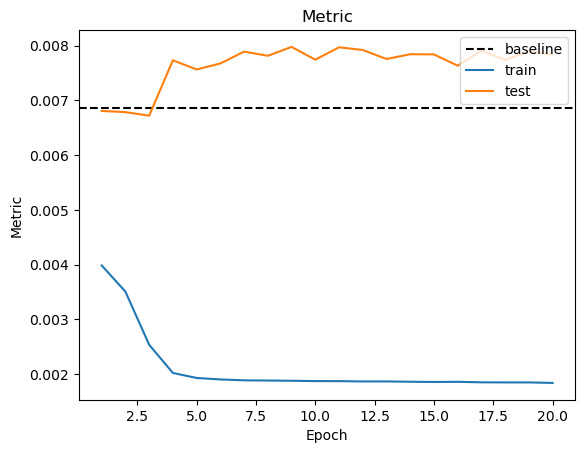

Success
NN (SigmaMinusReturnConstantWeights(q=0) criterion, Return features)
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return              9.42% ± 9.19%  12.86% ± 11.71%  27.21% ± 14.33%  21.06% ± 18.24%
sharpe ratio              1.02505         1.098274          1.89947         1.154165
difference         -3.44% ± 6.57%    0.00% ± 0.00%    6.15% ± 7.71%    0.00% ± 0.00%
information ratio       -0.523345              NaN         0.798316              NaN

NN (SigmaMinusReturnConstantWeights(q=0.5) criterion, Return features)
                  portfolio_train   baseline_train   portfolio_test    baseline_test
return             11.22% ± 9.20%  12.86% ± 11.71%  26.57% ± 14.56%  21.06% ± 18.24%
sharpe ratio             1.219441         1.098274         1.824312         1.154165
difference         -1.64% ± 6.48%    0.00% ± 0.00%    5.51% ± 7.34%    0.00% ± 0.00%
information ratio       -0.252538              NaN         0.750988              NaN



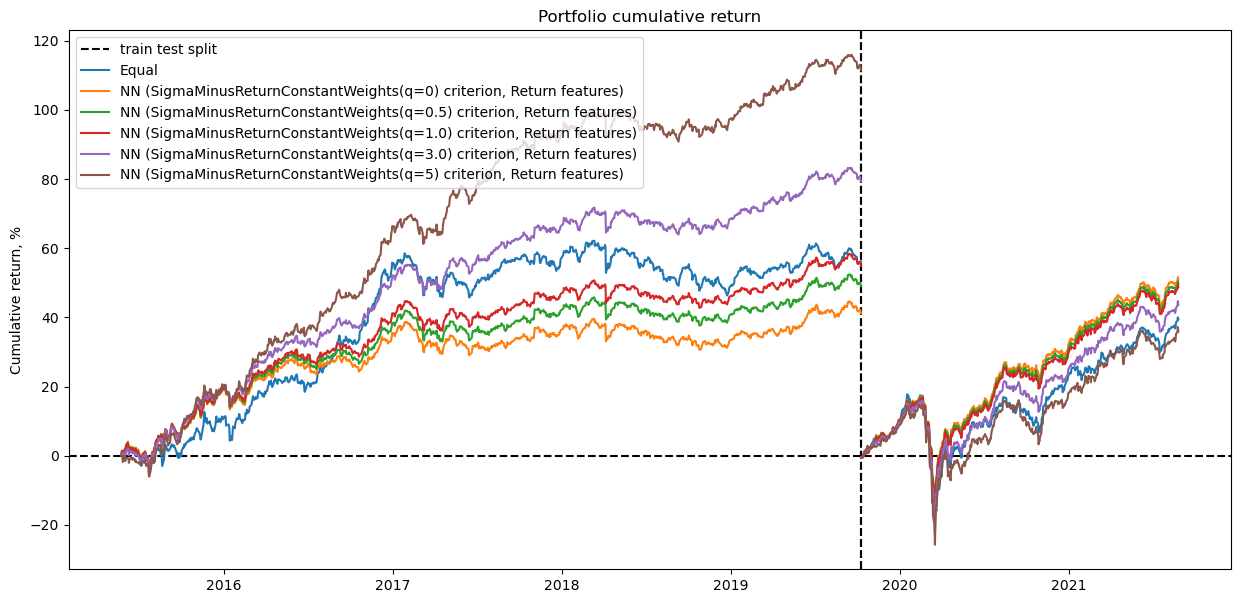

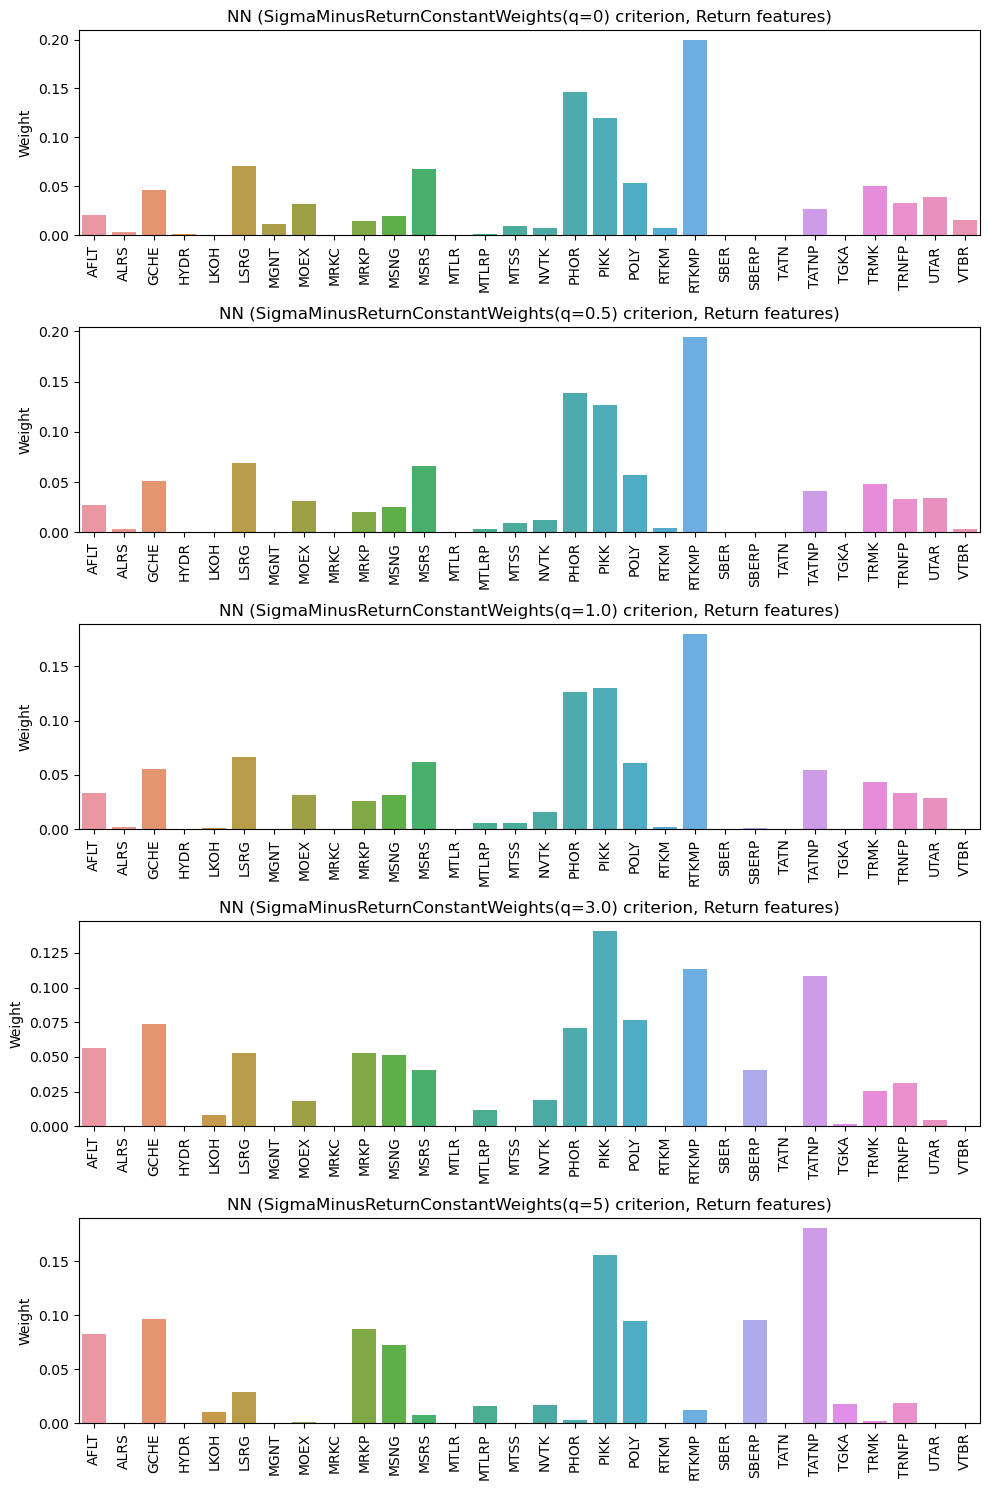

In [8]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
from timeit import default_timer as timer
from library.backtest import Strategy, compare_strategies


def train_loop(model, optimizer, criterion, train_loader) -> float:
    """
    Return Mean metric
    """
    train_loss = 0.0
    model.train()
    for features, targets in train_loader:
        features = features.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        predictions = model(features)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * features.shape[0]
    train_loss /= len(train_loader.dataset)
    return train_loss


@torch.no_grad()
def val_loop(model, criterion, val_loader) -> float:
    """
    Return Mean metric
    """
    val_loss = 0.0
    model.eval()
    for features, targets in val_loader:
        features = features.to(device)
        targets = targets.to(device)
        predictions = model(features)
        loss = criterion(predictions, targets)
        val_loss += loss.item() * features.shape[0]
    val_loss /= len(val_loader.dataset)
    return val_loss


def train_nn(model, optimizer, criterion, scheduler, train_loader, val_loader, n_epochs: int, baseline_loss: float, plot_baseline: bool, log_wandb: bool):
    train_losses, val_losses = [], []

    for epoch in tqdm(range(1, n_epochs + 1)):
        # Train
        start_time = timer()
        train_loss = train_loop(model, optimizer, criterion, train_loader)
        train_losses.append(train_loss)
        train_time = timer() - start_time

        # Validation
        start_time = timer()
        val_loss = val_loop(model, criterion, val_loader)
        val_losses.append(val_loss)
        val_time = timer() - start_time

        # Log lr
        lr = next(iter(optimizer.param_groups))['lr']

        # Scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Log record
        record = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'lr': lr,
            'train_time': train_time,
            'val_time': val_time,
        }
        if log_wandb:
            wandb.log(record)

        # Plot
        if epoch % 50 == 0 or epoch == n_epochs:
            clear_output()
            criterion.print_metric(train_losses[-1], val_losses[-1], baseline_loss)
            print(f'Train time: {train_time:.3f}s; val time: {val_time:.3f}s')
            if plot_baseline:
                plt.axhline(baseline_loss, linestyle='dashed', label='baseline', color='black')
            plt.plot(range(1, len(train_losses) + 1), train_losses, label='train')
            plt.plot(range(1, len(val_losses) + 1), val_losses, label='test')
            plt.title('Metric')
            plt.ylabel('Metric')
            plt.xlabel('Epoch')
            plt.legend(loc='upper right')
            plt.show()
    if log_wandb:
        wandb.finish()


@torch.no_grad()
def predict_nn(model, loader, observations: list[Observation]):
    model.eval()
    predictions = []
    for features, targets in loader:
        features = features.to(device)
        targets = targets.to(device)
        w = model(features)
        predictions.append(w)
    predictions = torch.cat(predictions, dim=0)
    dates = [observation.df_price_test.index[0] for observation in observations]
    result = pd.DataFrame(predictions.numpy(), index=dates, columns=observations[0].df_price_train.columns)
    assert np.allclose(result.sum(axis=1), 1.0)
    return result


class Net(nn.Module):
    def __init__(self, layer_sizes: list[int]):
        super().__init__()
        args = []
        for i in range(1, len(layer_sizes) - 1):
            args += [nn.Linear(layer_sizes[i - 1], layer_sizes[i]), nn.ReLU()]
        args += [nn.Linear(layer_sizes[-2], layer_sizes[-1])]
        self.net = nn.Sequential(
            *args,
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)


def get_strategy(model):
    return Strategy(
        name=f'NN (SigmaMinusReturnConstantWeights(q={Q}) criterion, Return features)',
        get_train_w=lambda: predict_nn(model, train_loader, observations_train),
        get_test_w=lambda: predict_nn(model, val_loader, observations_test),
    )


strategies = []
for Q in [0, 0.5, 1.0, 3.0, 5]:
    LOG_WANDB = False
    N_EPOCHS = 20
    LR = 1e-3

    layer_sizes = [30, 50, 50, 30]

    print(f'{N_EPOCHS} epochs')
    print(f'LayerSizes: {layer_sizes}')
    print(f'LR = {LR}')

    model = Net(layer_sizes=layer_sizes).to(device)

    returns = torch.concat([b[1] for b in val_loader], dim=0)

    # criterion = ReturnCriterion()
    # baseline_loss = criterion(baseline_w, returns).item()

    criterion = SigmaMinusReturnConstantWeights(q=Q)
    baseline_loss = criterion(baseline_w, returns).item()

    print(f'{baseline_loss = }')
    print(model)
    print(criterion)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = None

    torch.manual_seed(0)
    try:
        train_nn(model, optimizer, criterion, scheduler, train_loader=train_loader, val_loader=val_loader, n_epochs=N_EPOCHS, baseline_loss=baseline_loss, plot_baseline=True, log_wandb=LOG_WANDB)
    except KeyboardInterrupt:
        print('KeyboardInterrupt')
        if LOG_WANDB:
            wandb.finish()
    print('Success')
    strategies.append(get_strategy(model))

portfolio_stats = compare_strategies(strategies, observations_train, observations_test, cache_folder='cache/nn/SigmaMinusReturnConstantWeights on returns', use_cache=False)